# Performance metrics for clustering

## With known ground truth

For this types of metrics, we suppose that we have a dataset $X = (x_1, \ldots, x_n)$ and that we also know the **real classes** (also known as ground truth) of the instances of the dataset $T = (t_1, \ldots, t_n)$. Additinally, we ran a clustering algorithm and we got **predicted classes** (clusters) $C = (c_1, \ldots, c_n)$. The aim of these metrics is to compare the assignments of $T$ with the predicted ones of $C$ to measure the agreement.

**Important:** It does not make sense to apply metrics for raw classification. The labels of $C$ are arbitrary, in the sense that the number assigned to each cluster is purely random. For this reason, the algorithm must be **independent of relabelling** of the clusters.

### Rand Index

One of the simplest and most common metrics for clustering is the so-called **Rand Index**. The idea is the following. For each pair of samples $\{x_i, x_j\} \subseteq X$ we can analyze whether their real labels in $T$ are equal or not and whether the cluster algorithm assigned them the same label in $C$ (even though the chosen their label in $T$ may be different from the one of $C$. Let us consider the following quantities:

- $a_{00}:$ Number of (unordered) pairs $\{x_i, x_j\}$ such that $t_i = t_j$ and $c_i = c_j$ (both labellings agree that they belong to the same cluster).
- $a_{11}:$ Number of (unordered) pairs $\{x_i, x_j\}$ such that $t_i \neq t_j$ and $c_i \neq c_j$ (both labellings agree that they do not belong to the same cluster).

The Rand Index is defined as

$$
    \textrm{RandIndex} = \frac{a_{00} + a_{11}}{\begin{pmatrix}n \\ 2\end{pmatrix}},
$$

where recall that $\begin{pmatrix}n \\ 2\end{pmatrix}$ is the combinatorial number

$$
    \begin{pmatrix}n \\ 2\end{pmatrix} = \frac{n(n-1)}{2}.
$$

The Rand Index can be understood as a measure of the agreement of the two 'judges': the true labels and the clustering algorithm. The larger the Rand Index, the better the clustering. In other words, if we introduce $a_{01}$ (resp. $a_{10}$) as the number of pairs $\{x_i, x_j\}$ such that $t_i = t_j$ (resp. $t_i \neq t_j$) and $c_i \neq c_j$ (resp. $c_i = c_j$), then it can be written as


$$
    \textrm{RandIndex} = \frac{a_{00} + a_{11}}{a_{00} + a_{01} + a_{10}+ a_{11}} = A_o.
$$

Observe that, despite that $\textrm{RandIndex}$ computes the rate between observed agreement and total number of pairs, it does not discount the number of agreements obtained by pure chance. For this purpose, the **expected agreement** $A_e$ can be computed from the contingency matrix of the data. With this value, the **adjusted Rand Index** is defined as

$$
    \textrm{AdjustedRandIndex} = \frac{A_o - A_e}{1-A_e},
$$

**Remark:** In qualitative analysis, this index is known as Krippendorff's $\alpha$ coefficient.

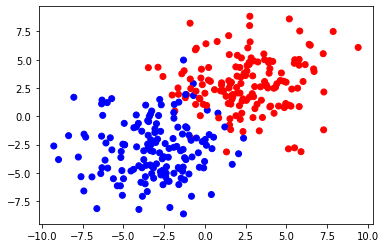

In [5]:
import sklearn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.metrics import adjusted_rand_score
import numpy as np

X, y = make_blobs(n_samples=300, n_features=2, centers=[[-3,-3], [3,3]], cluster_std=2.5, random_state=23)

plt.figure()
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.bwr)

Adjusted Rand Index:  0.845885391219376


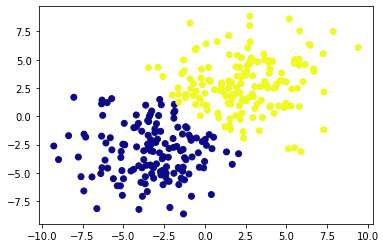

In [6]:
# With KMeans
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, n_init=1, max_iter=100, random_state=23)
kmeans.fit(X)
labels = kmeans.predict(X)

plt.scatter(X[:,0], X[:,1], c=labels, cmap='plasma')

print('Adjusted Rand Index: ', adjusted_rand_score(y, labels))

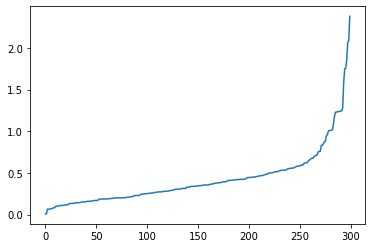

In [52]:
# Choosing the best epsilon for DBSCAN

from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=3)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

Adjusted Rand Index:  0.3596336250520037


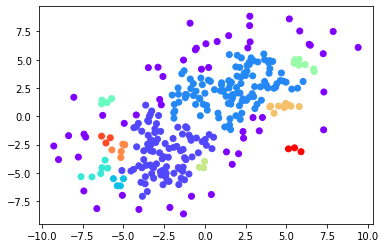

In [12]:
# With DBSCAN
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.7, min_samples=3)
dbscan.fit(X)

labels = dbscan.labels_

plt.scatter(X[:,0], X[:,1], c=labels, cmap='rainbow')
print('Adjusted Rand Index: ', adjusted_rand_score(y, labels))

Text(0.5, 1.0, 'RandInd = 0.992')

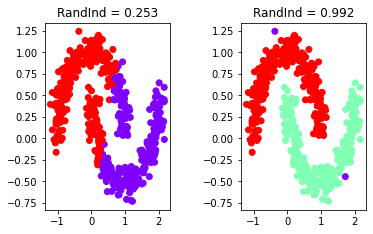

In [71]:
# Another example: Moons

from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

X, y = make_moons(n_samples=500, noise=0.1, random_state=42)

kmeans = KMeans(n_clusters=2, n_init=1, max_iter=100, random_state=23)
kmeans.fit(X)
labels_kmeans = kmeans.labels_
rand_kmeans = adjusted_rand_score(y, labels_kmeans)

dbscan = DBSCAN(eps=0.15, min_samples=5)
dbscan.fit(X)
labels_dbscan = dbscan.labels_
rand_dbscan = adjusted_rand_score(y, labels_dbscan)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.tight_layout(pad=4.0)
ax1.scatter(X[:,0], X[:,1], c=labels_kmeans, cmap='rainbow')
ax1.set_title('RandInd = ' + str(round(rand_kmeans,3)))

ax2.scatter(X[:,0], X[:,1], c=labels_dbscan, cmap='rainbow')
ax2.set_title('RandInd = ' + str(round(rand_dbscan,3)))

## With unknown ground truth: Silhouette

Suppose that we have samples $X = \{x_1, \ldots, x_n\}$ with predicted classes (clusters) $C = \{c_1, \ldots, c_n\}$. In this case, there is no information of the real classes $T$, so we have to discuss how good is the division $C$ **abstractly**.

For convenience, let us define $\mathcal{C}_k$ as the set of elements of $X$ in the $i$-th cluster. Given $x_i \in X$ belonging to cluster $\mathcal{C}_k$, we define its **mean intracluster distance** as

$$
    a(x_i) = \frac{1}{|\mathcal{C}_k|-1} \sum_{x_j \in \mathcal{C}_k-\{x_i\}} d(x_i, x_j),
$$

where $d(x_i, x_j)$ denotes the distance between $x_i$ and $x_j$. On the other hand, it can be also defined the **mean intercluster distance** as

$$
    b(x_i) = \min_{l \neq k}\frac{1}{|\mathcal{C}_l|} \sum_{x_j \in \mathcal{C}_l} d(x_i, x_j).
$$

These two quantities can be put together to define the so-called **silhouette** of $x_i$ as

$$
    S(x_i) = \frac{b(x_i)-a(x_i)}{\max\{a(x_i),b(x_i)\}}
$$

The final silhouette is
$$
    S = \frac{1}{n} \sum_{i=1}^n S(x_i).
$$

Silhouette:  0.48181187645866497


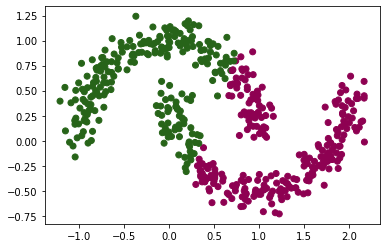

In [14]:
# With KMeans
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

kmeans = KMeans(n_clusters=2, n_init=1, max_iter=100, random_state=23)
kmeans.fit(X)
labels = kmeans.predict(X)

plt.scatter(X[:,0], X[:,1], c=labels, cmap=plt.cm.PiYG)

print('Silhouette: ', silhouette_score(X, labels))

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

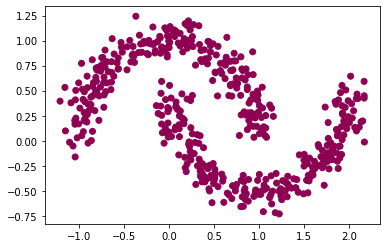

In [15]:
# With DBSCAN
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.7, min_samples=3)
dbscan.fit(X)

labels = dbscan.labels_

plt.scatter(X[:,0], X[:,1], c=labels, cmap=plt.cm.PiYG)
print('Silhouette: ', silhouette_score(X, labels))

Text(0.5, 1.0, 'Silhouette = 0.263')

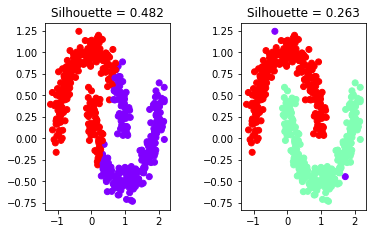

In [16]:
# Another example: Moons

from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

X, y = make_moons(n_samples=500, noise=0.1, random_state=42)

kmeans = KMeans(n_clusters=2, n_init=1, max_iter=100, random_state=23)
kmeans.fit(X)
labels_kmeans = kmeans.labels_
silhouette_kmeans = silhouette_score(X, labels_kmeans)

dbscan = DBSCAN(eps=0.15, min_samples=5)
dbscan.fit(X)
labels_dbscan = dbscan.labels_
silhouette_dbscan = silhouette_score(X, labels_dbscan)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.tight_layout(pad=4.0)
ax1.scatter(X[:,0], X[:,1], c=labels_kmeans, cmap='rainbow')
ax1.set_title('Silhouette = ' + str(round(silhouette_kmeans,3)))

ax2.scatter(X[:,0], X[:,1], c=labels_dbscan, cmap='rainbow')
ax2.set_title('Silhouette = ' + str(round(silhouette_dbscan,3)))

### Using Silhouette for choosing the number of clusters in $K$-Means

The silhouette metric can be used for deciding the best number of clusters, $K$, in the $K$-Means algorithm. For this purpose, we compute the silhouette values for each of the samples of the dataset. Grouping together the samples by the predicted cluster and sorting the values of silhouette, we can obtain the so-called **silhouette plot** that shows how the value of the quality metric varies on each cluster and their size.

A rule-of-thumb is to choose the value of $K$ that create clusters of (approximately) the same size and such that most of their elements have large values, near to the mean silhouette of the dataset. For conducting this comparison, it is also customary to plot the main value of silhouette as a vertical line on the plot.

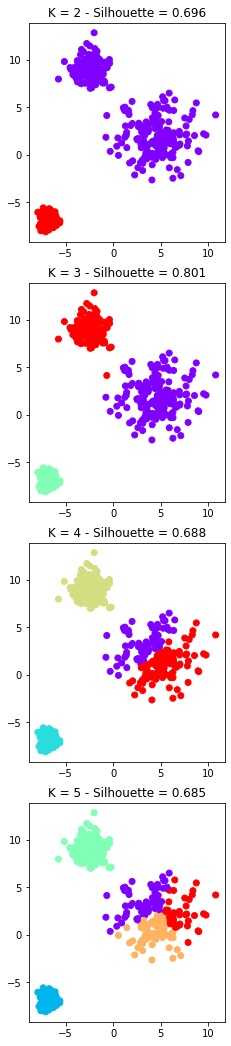

In [92]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

X, y = make_blobs(n_samples=500, cluster_std=[1.0, 2.0, 0.5], random_state=42)

MAX_CLUSTERS = 5

fig, ax = plt.subplots(MAX_CLUSTERS-1, figsize=(15,15))
fig.tight_layout(pad=3.0, w_pad=1.0, h_pad=2.0)
for i in range(2, MAX_CLUSTERS + 1):
    kmeans = KMeans(n_clusters=i, n_init=1, max_iter=100, random_state=23)
    kmeans.fit(X)
    labels = kmeans.labels_
    ax[i-2].set_aspect('equal')
    ax[i-2].scatter(X[:,0], X[:,1], c=labels, cmap='rainbow')
    ax[i-2].set_title('K = ' + str(i) + ' - Silhouette = ' + str(round(silhouette_score(X, labels),3)))
    

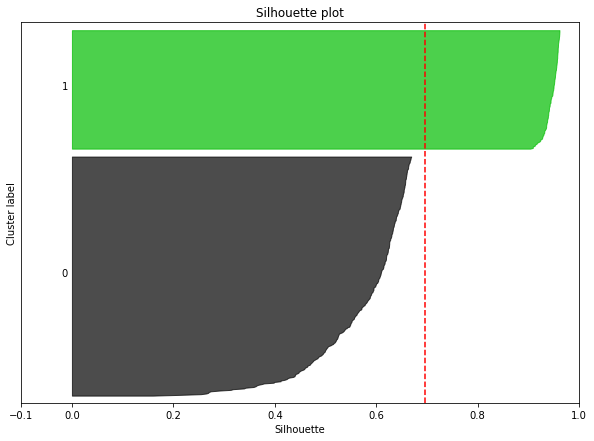

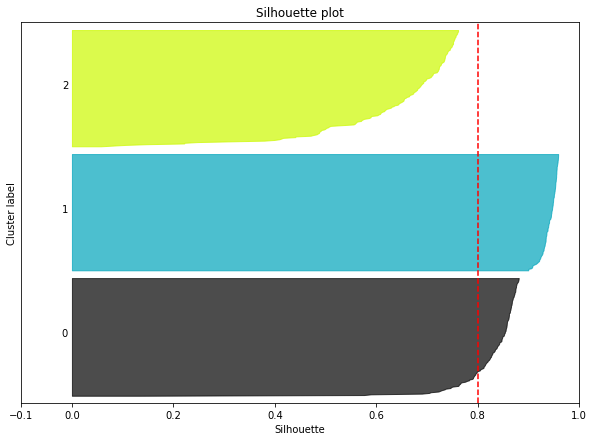

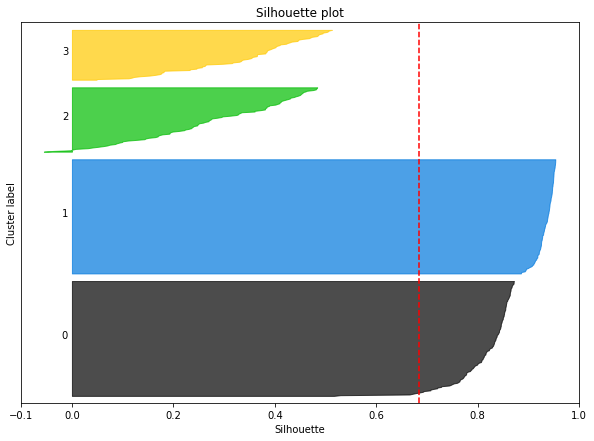

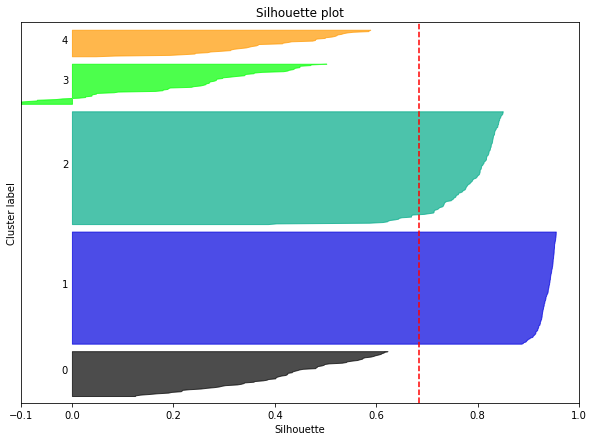

In [115]:
import matplotlib.cm as cm

for n_clusters in range(2, MAX_CLUSTERS + 1):
    fig, ax = plt.subplots(1)
    fig.set_size_inches(10, 7)

    ax.set_xlim([-0.05, 1])
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    
    clusterer = KMeans(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        cluster_silhouette_values.sort()

        size_cluster_i = cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax.text(-0.02, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax.set_title("Silhouette plot")
    ax.set_xlabel("Silhouette")
    ax.set_ylabel("Cluster label")
    
    # The vertical line for average silhouette score
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

In this case, the preferred value of $K$ would be $K=3$. First, we observe that $K=2, 3$ are good choices since the size of the clusters is similar and many of the points have high values of silhouette ('rectangular shape'). For $K \geq 4$, small clusters with very poor values of silhouette arise ('triangular shape'). Between $K=2$ and $K=3$, the choice may be $K=3$ since the global value of silhouette is greater.

---

Created by **Ángel González Prieto** (angelgonzalezprieto@ucm.es)

<img src="https://licensebuttons.net/l/by-nc-sa/3.0/88x31.png">